In [1]:
%pylab nbagg
%load_ext autoreload
%autoreload 2
%load_ext memory_profiler

Populating the interactive namespace from numpy and matplotlib


In [2]:
import fastcat.fastcat as fc
from glob import glob

## First I'll look at the detector MTF

### I'll load all of the kernels 

In [3]:
spectra = glob('../fastcat/data/MV_spectra/*.txt')
phantoms = ['XCAT','XCAT2','Catphan_515','Catphan_MTF']
MV_detectors = glob('../fastcat/data/Detectors/*')

dispatcher={'Catphan_515':fc.Catphan_515,
            'XCAT':fc.XCAT2,
            'XCAT2':fc.XCAT,
            'Catphan_MTF':fc.Catphan_MTF}

<IPython.core.display.Javascript object>


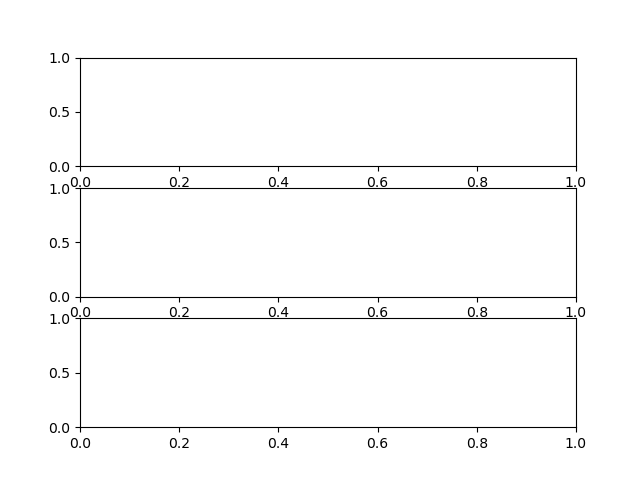

../fastcat/data/MV_spectra/Al_spectrum_6.txt ../fastcat/data/Detectors/CWO-784-micrometer
Calculation:  1 / 50
Calculation:  2 / 50
Calculation:  3 / 50
Calculation:  4 / 50
Calculation:  5 / 50
Calculation:  6 / 50
Calculation:  7 / 50
Calculation:  8 / 50
Calculation:  9 / 50
Calculation:  10 / 50
Calculation:  11 / 50
Calculation:  12 / 50
Calculation:  13 / 50
Calculation:  14 / 50
Calculation:  15 / 50
Calculation:  16 / 50
Calculation:  17 / 50
Calculation:  18 / 50
Calculation:  19 / 50
Calculation:  20 / 50
Calculation:  21 / 50
Calculation:  22 / 50
Calculation:  23 / 50
Calculation:  24 / 50
Calculation:  25 / 50
Calculation:  26 / 50
Calculation:  27 / 50
Calculation:  28 / 50
Calculation:  29 / 50
Calculation:  30 / 50
Calculation:  31 / 50
Calculation:  32 / 50
Calculation:  33 / 50
Calculation:  34 / 50
Calculation:  35 / 50
Calculation:  36 / 50
Calculation:  37 / 50
Calculation:  38 / 50
Calculation:  39 / 50
Calculation:  40 / 50
Calculation:  41 / 50
Calculation:  42 

In [7]:
s = fc.Spectrum()

contrasts = []
mtfs = []
label = []

fig, axs = plt.subplots(3, 1)

nviews = 360

for phan in phantoms[:1]:
    phantom = dispatcher[phan]()
    for jj in [1,2]:
        for kk in [2,5,8]:
            spectrum = sorted(spectra)[jj]
            det = sorted(MV_detectors)[kk]
            print(spectrum, det)
            if jj == 1:
                s = fc.calculate_spectrum(120, 12, 3, 50)
                s.attenuate(0.2,fc.get_mu(z=13))
            else:
                s.load(spectrum.split('/')[-1].split('.')[0])
                
#             s.attenuate(0.2,fc.get_mu(z=82))
            kernel = fc.Kernel(s, det.split('/')[-1].split('.')[0])
#             kernel.get_plot_mtf_real(axs[2])
#             mtfs.append([kernel.freq,kernel.mtf])
            angles = np.linspace(0,np.pi*2,nviews)#480)        

            phantom.return_projs(kernel,s,angles,det_on=True,scat_on=False,mgy=7/nviews)
            phantom.reconstruct('FDK')
#             phantom.reconstruct('CGLS')
            contrasts.append(phantom.img.T)
            label.append([phan,spectrum,det])
            
#             break
#         break
#     break
    

In [28]:
import os
import imageio
import re

png_dir = 'pngs/'
images = []

for file_name in sorted(os.listdir(png_dir)):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))
imageio.mimsave('pngs/movie_gray.gif', images)

<IPython.core.display.Javascript object>


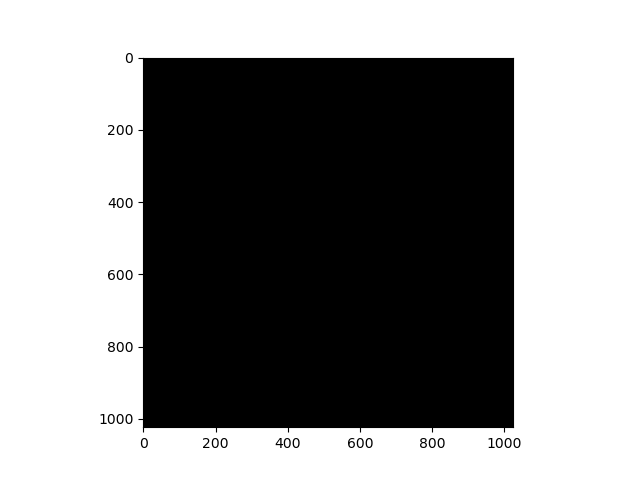

In [27]:
plt.figure()

for ii in range(phantom.img.T.shape[2]):
    plt.imshow(phantom.img.T[:,:,ii],cmap='gray')
    plt.savefig(f'pngs/{ii:02d}')

In [61]:
phantom.reconstruct('FDK')

<IPython.core.display.Javascript object>


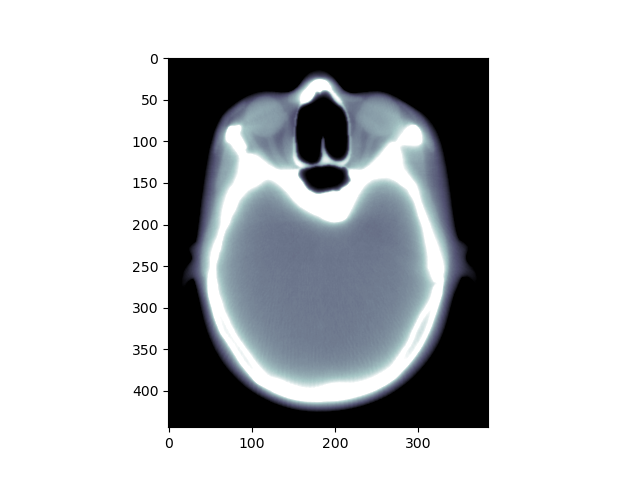

In [18]:
class IndexTracker(object):
    def __init__(self, ax, X):
        self.ax = ax
        ax.set_title('use scroll wheel to navigate images')

        self.X = X
        rows, cols, self.slices = X.shape
        self.ind = self.slices//2

        self.im = ax.imshow(self.X[:, :, self.ind],cmap='bone',vmax=400,vmin=-400)
        self.update()

    def onscroll(self, event):
        print("%s %s" % (event.button, event.step))
        if event.button == 'up':
            self.ind = (self.ind + 1) % self.slices
        else:
            self.ind = (self.ind - 1) % self.slices
        self.update()

    def update(self):
        self.im.set_data(self.X[:, :, self.ind])
        ax.set_ylabel('slice %s' % self.ind)
        self.im.axes.figure.canvas.draw()

fig, ax = plt.subplots(1, 1)

index = 7

sc = contrasts[0]

mm = np.mean(sc[385:410,610:640,index])
mm_air = np.mean(sc[-200:,-200:,index])

im_HU = (sc[:,:,index] - mm)/(mm_air - mm)*-1000

#     plt.imshow(sc[:,:,15],cmap='gray',vmax=mm+3*ss,vmin=mm-3*ss)
plt.imshow(np.rot90(im_HU,3)[270:-310,320:-320],cmap='bone',vmax=400,vmin=-400)
# plt.axis('off')


# X = np.array(np.rot90(im_HU,3)[270:-310,320:-320])

# tracker = IndexTracker(ax, X)

# fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
# plt.show()

In [8]:
np.save('revised_weights_version',contrasts)

<IPython.core.display.Javascript object>


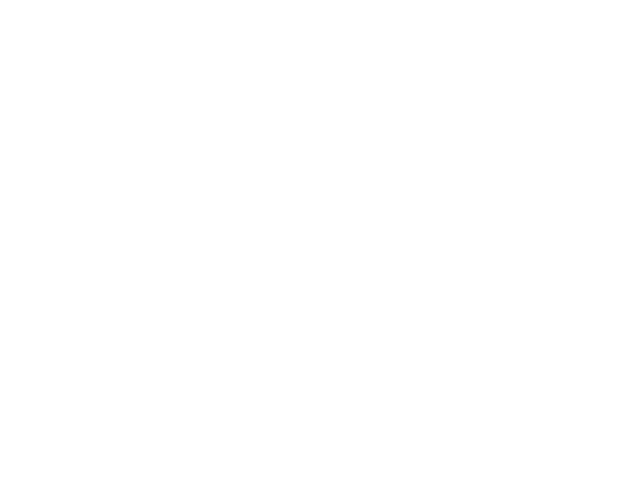

IndexError: index 15 is out of bounds for axis 2 with size 10

In [52]:
plt.figure()

sc = phantom.img.T

mm = np.nanmean(sc[401:446,307:350,15])
mm_air = np.nanmean(sc[400:,400:,15])

im_HU = (sc[:,:,15] - mm)/(mm_air - mm)*-1000

#     plt.imshow(sc[:,:,15],cmap='gray',vmax=mm+3*ss,vmin=mm-3*ss)
plt.imshow(np.rot90(im_HU,3)[150:390,:],cmap='bone',vmax=240,vmin=-160)
plt.axis('off')

In [72]:
MV_scan = phantom.img.T
np.save('scan_Pb_CWO',MV_scan)

<IPython.core.display.Javascript object>


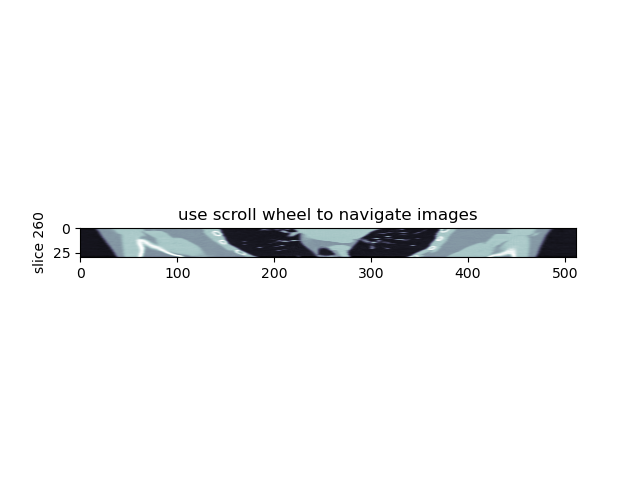

In [12]:
class IndexTracker(object):
    def __init__(self, ax, X):
        self.ax = ax
        ax.set_title('use scroll wheel to navigate images')

        self.X = X
        rows, cols, self.slices = X.shape
        self.ind = self.slices//2

        self.im = ax.imshow(self.X[:, :, self.ind],cmap='bone')
        self.update()

    def onscroll(self, event):
        print("%s %s" % (event.button, event.step))
        if event.button == 'up':
            self.ind = (self.ind + 1) % self.slices
        else:
            self.ind = (self.ind - 1) % self.slices
        self.update()

    def update(self):
        self.im.set_data(self.X[:, :, self.ind])
        ax.set_ylabel('slice %s' % self.ind)
        self.im.axes.figure.canvas.draw()

fig, ax = plt.subplots(1, 1)

X = np.array(phantom.img.transpose([0,2,1]))

tracker = IndexTracker(ax, X)

fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

In [14]:
np.save('head_scans_no_noise',contrasts)

<IPython.core.display.Javascript object>


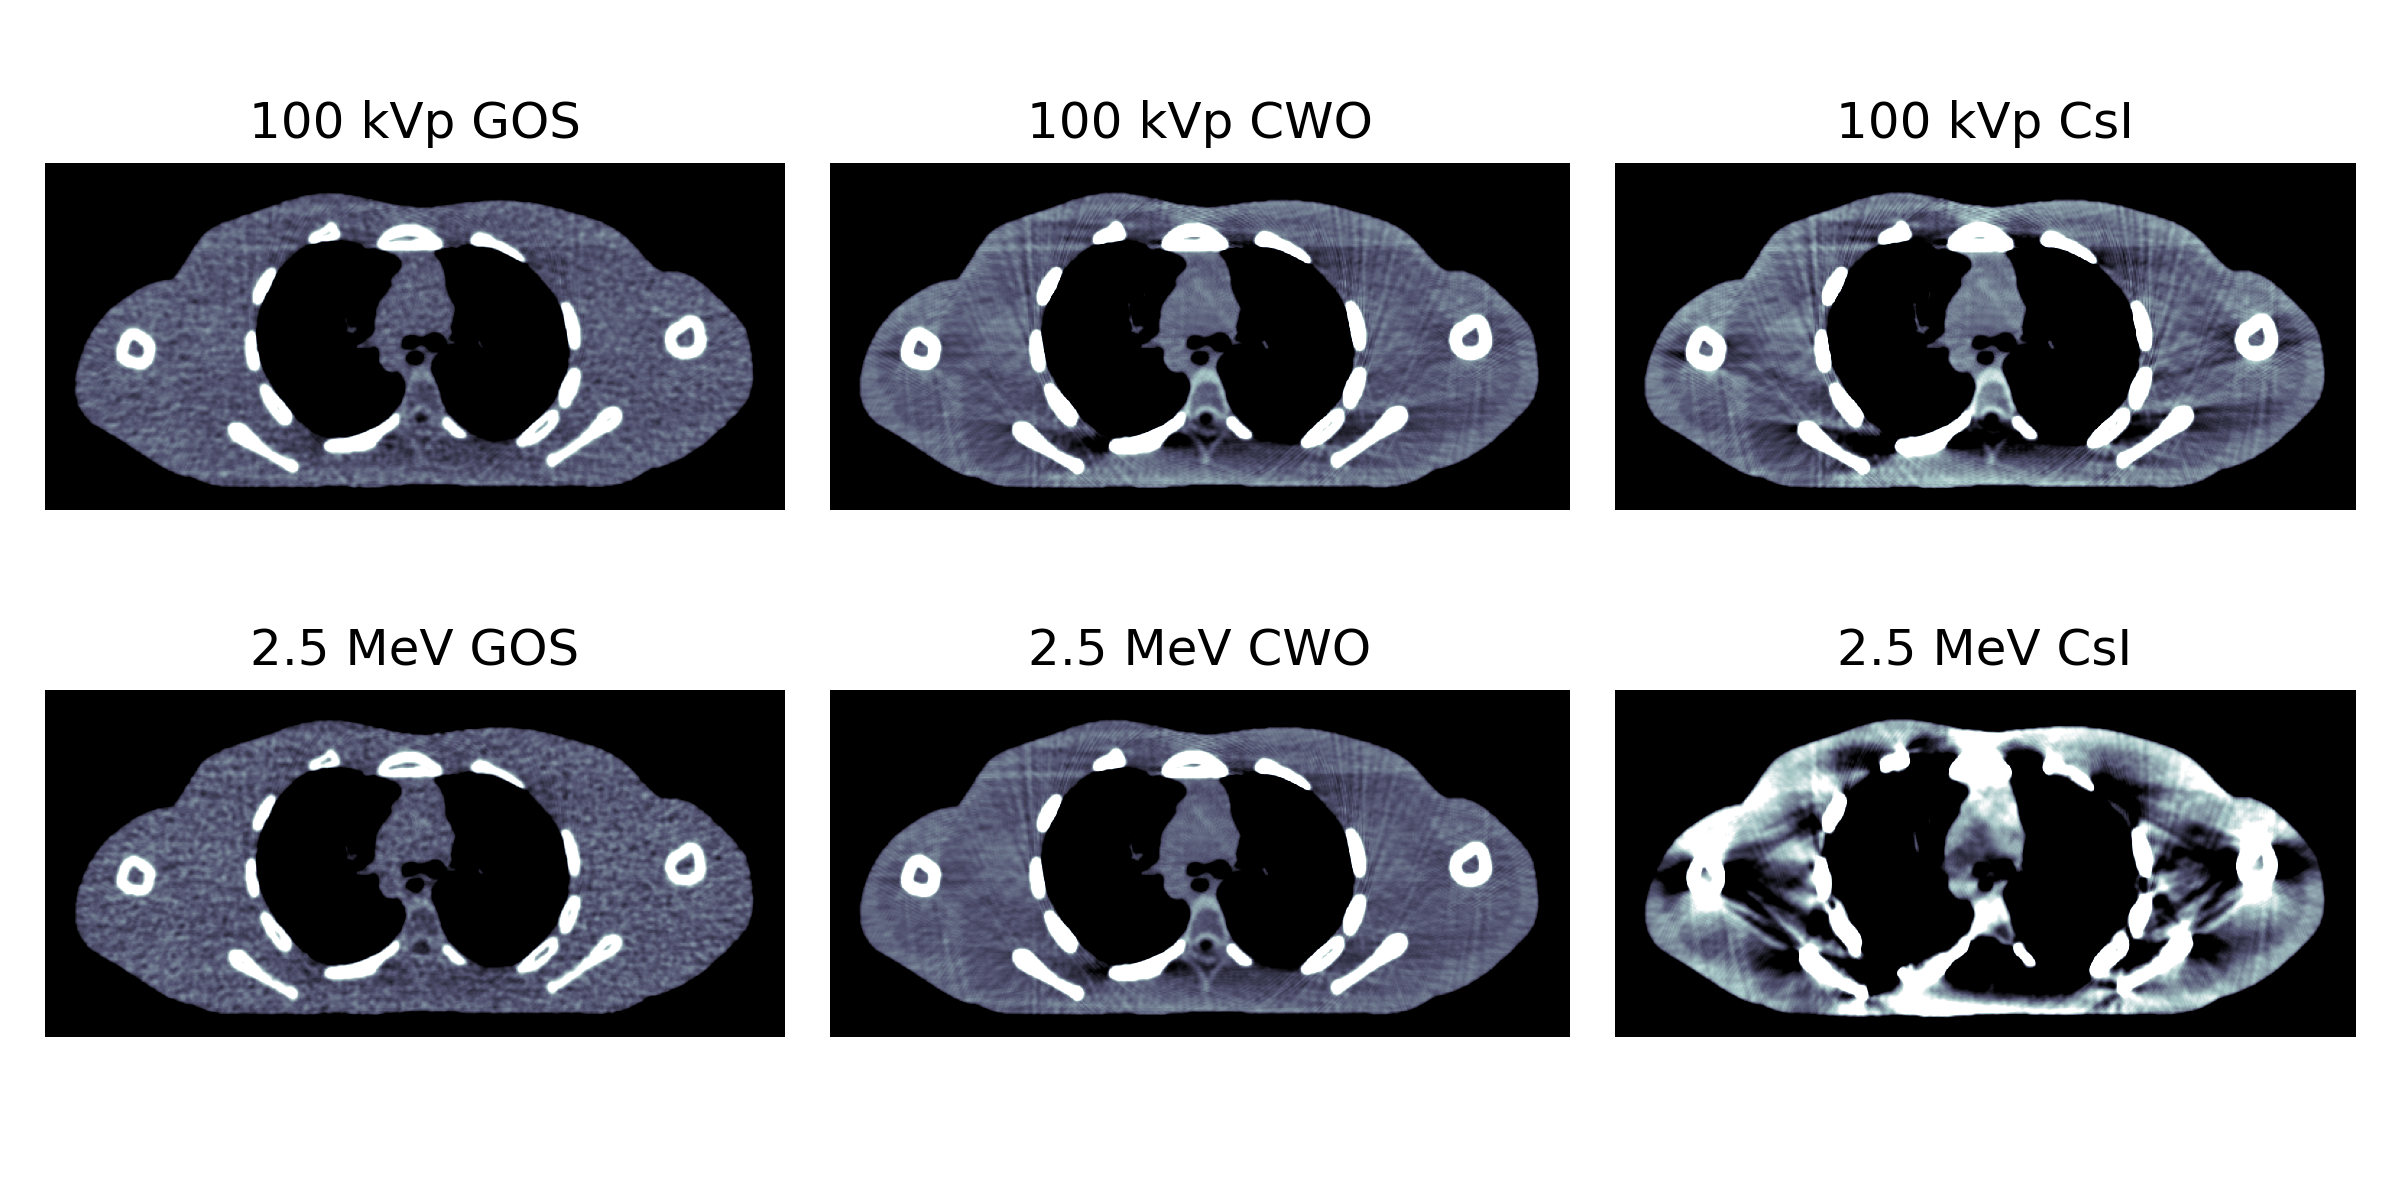

In [164]:
plt.figure(figsize=[8,4],dpi=300)

scans = glob('XCATs/scan*')

small_titles = ['100 kVp GOS','100 kVp CWO','100 kVp CsI','2.5 MeV GOS','2.5 MeV CWO','2.5 MeV CsI']

for ii, scan in enumerate(sorted(scans,reverse=True)):
    
    sc = np.load(scan)
    
    plt.subplot(2,3,ii+1)
    
    plt.title(small_titles[ii])#scan.split('/')[-1].split('.')[0].split('scan_')[1])
    
    mm = np.mean(sc[401:446,307:350,15])
    mm_air = np.mean(sc[400:,400:,15])
    
    im_HU = (sc[:,:,15] - mm)/(mm_air - mm)*-1000
    
#     plt.imshow(sc[:,:,15],cmap='gray',vmax=mm+3*ss,vmin=mm-3*ss)
    plt.imshow(np.rot90(im_HU,3)[150:390,:],cmap='bone',vmax=240,vmin=-160)
    plt.axis('off')

plt.tight_layout()
plt.savefig('/home/xcite/fastcat_paper_2_tmi/figures/XCATs.pdf')

In [4]:
contrasts = np.load('revised_weights_version.npy')

<IPython.core.display.Javascript object>


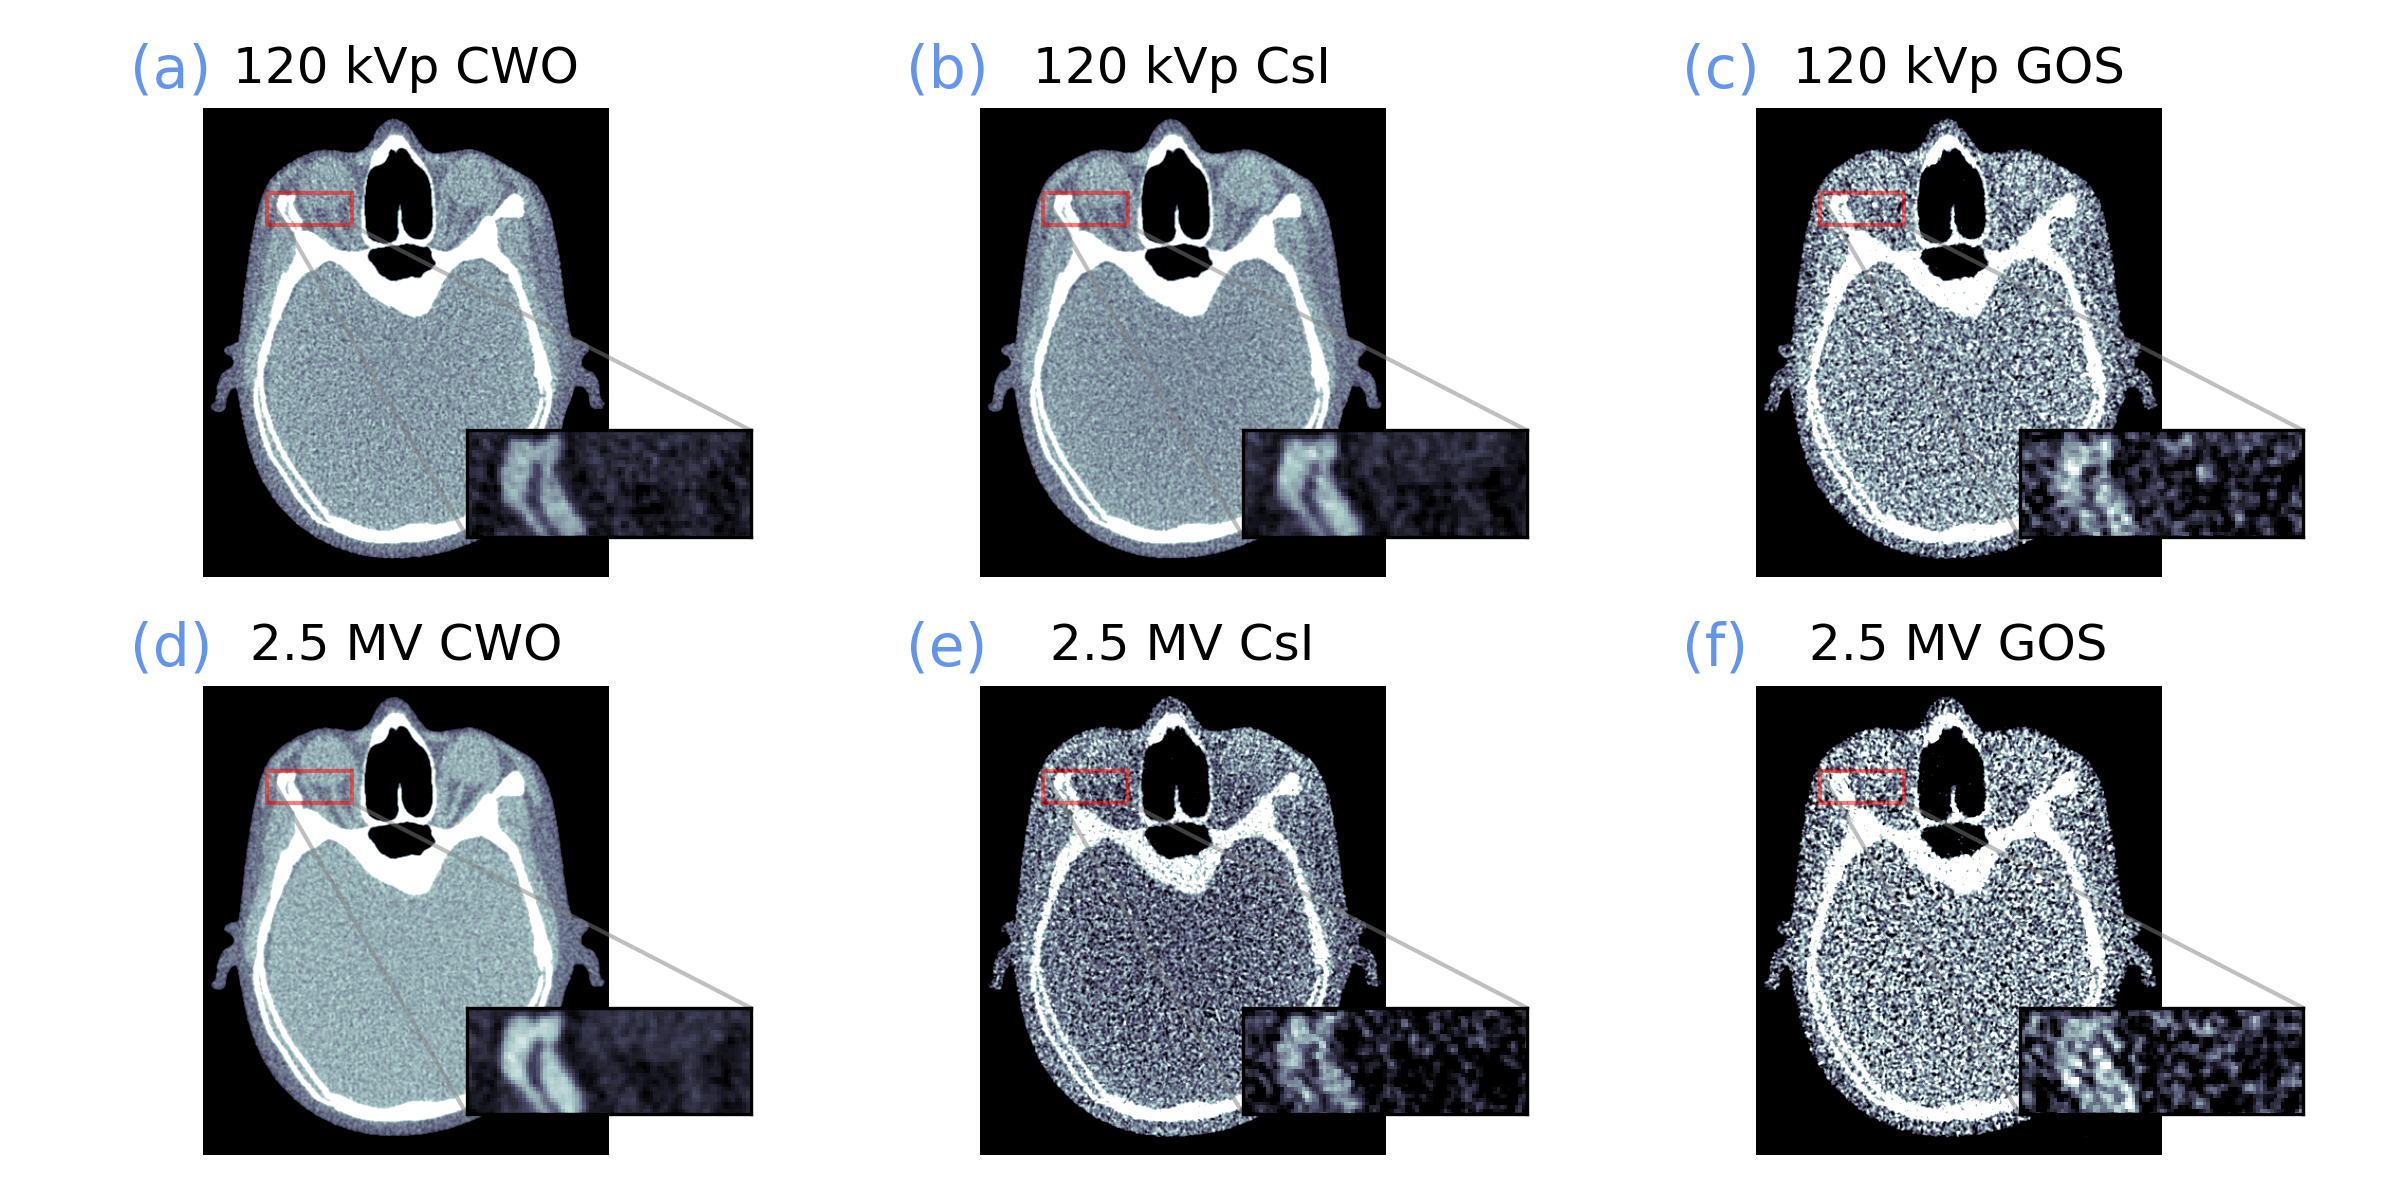

In [19]:
plt.figure(figsize=[8,4],dpi=300)
import matplotlib.patches as mpatches
# scans = glob('XCATs/scan*')
index = 7

small_titles = ['120 kVp CWO','120 kVp CsI','120 kVp GOS','2.5 MV CWO','2.5 MV CsI','2.5 MV GOS']
alph = ['(a)','(b)','(c)','(d)','(e)','(f)']

h,w = np.rot90(contrasts[0][:,:,index],3)[270:-310,320:-320].shape

X, Y = np.ogrid[:h, :w]
x, y = h//2,w//2

center = [x,y]

dist = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

values = [0.00708,0.008,0.01]
labs = ['Body','Muscle','Skull']

for ii, sc in enumerate(contrasts):
    
    plt.subplot(2,3,ii+1)
    plt.title(small_titles[ii])#scan.split('/')[-1].split('.')[0].split('scan_')[1])

    if ii == 10:
        im = np.fliplr(np.load('../../XCAT_phantom/head_gt.npy'))
        plt.imshow(im,cmap='bone')
        plt.text(-70,-20,alph[ii],color='cornflowerblue',fontsize=14)
        
        ax = plt.gca()
        axins = ax.inset_axes([0.65, -0.25, 0.7, 0.9])

        im2 = axins.imshow(im,cmap='bone')
        # ax2.set_xlim([-0.05,0.2])
        # ax2.set_ylim([0.05,0.11])
        # sub region of the original image
        x1, x2, y1, y2 = 60, 140, 110, 80
        axins.set_xlim(x1, x2)
        axins.set_ylim(y1, y2)
        axins.set_xticklabels('')

        axins.set_xticks([])
        axins.set_yticks([])

        ax.indicate_inset_zoom(axins,ec='red')
        plt.axis('off')
        
        # get the colors of the values, according to the 
        # colormap used by imshow
        colors = [ im2.cmap(im2.norm(value)) for value in values]
        # create a patch (proxy artist) for every color 
        patches = [ mpatches.Patch(color=colors[i], label="{l}".format(l=labs[i]) ) for i in range(len(values)) ]
        # put those patched as legend-handles into the legend
        plt.legend(handles=patches, bbox_to_anchor=(0.65, 1), loc=2, borderaxespad=0. )
    else:
    
        mm = np.mean(sc[385:410,610:640,index])
        mm_air = np.mean(sc[-200:,-200:,index])

        im_HU = (sc[:,:,index] - mm)/(mm_air - mm)*-1000

        im = np.rot90(im_HU,3)[270:-310,320:-320]

        im[dist > 245] = -1000

    #     plt.imshow(sc[:,:,15],cmap='gray',vmax=mm+3*ss,vmin=mm-3*ss)
        plt.imshow(im,cmap='bone',vmax=400,vmin=-400)
        plt.text(-70,-20,alph[ii],color='cornflowerblue',fontsize=14)
        plt.axis('off')

        ax = plt.gca()

        axins = ax.inset_axes([0.65, -0.25, 0.7, 0.9])

        axins.imshow(im,cmap='bone',vmax=1000,vmin=-100)
        # ax2.set_xlim([-0.05,0.2])
        # ax2.set_ylim([0.05,0.11])
        # sub region of the original image
        x1, x2, y1, y2 = 60, 140, 110, 80
        axins.set_xlim(x1, x2)
        axins.set_ylim(y1, y2)
        axins.set_xticklabels('')

        axins.set_xticks([])
        axins.set_yticks([])

        ax.indicate_inset_zoom(axins,ec='red')

plt.tight_layout()
plt.savefig('/home/xcite/fastcat_paper_2_tmi/figures/XCATs.pdf') #

<IPython.core.display.Javascript object>


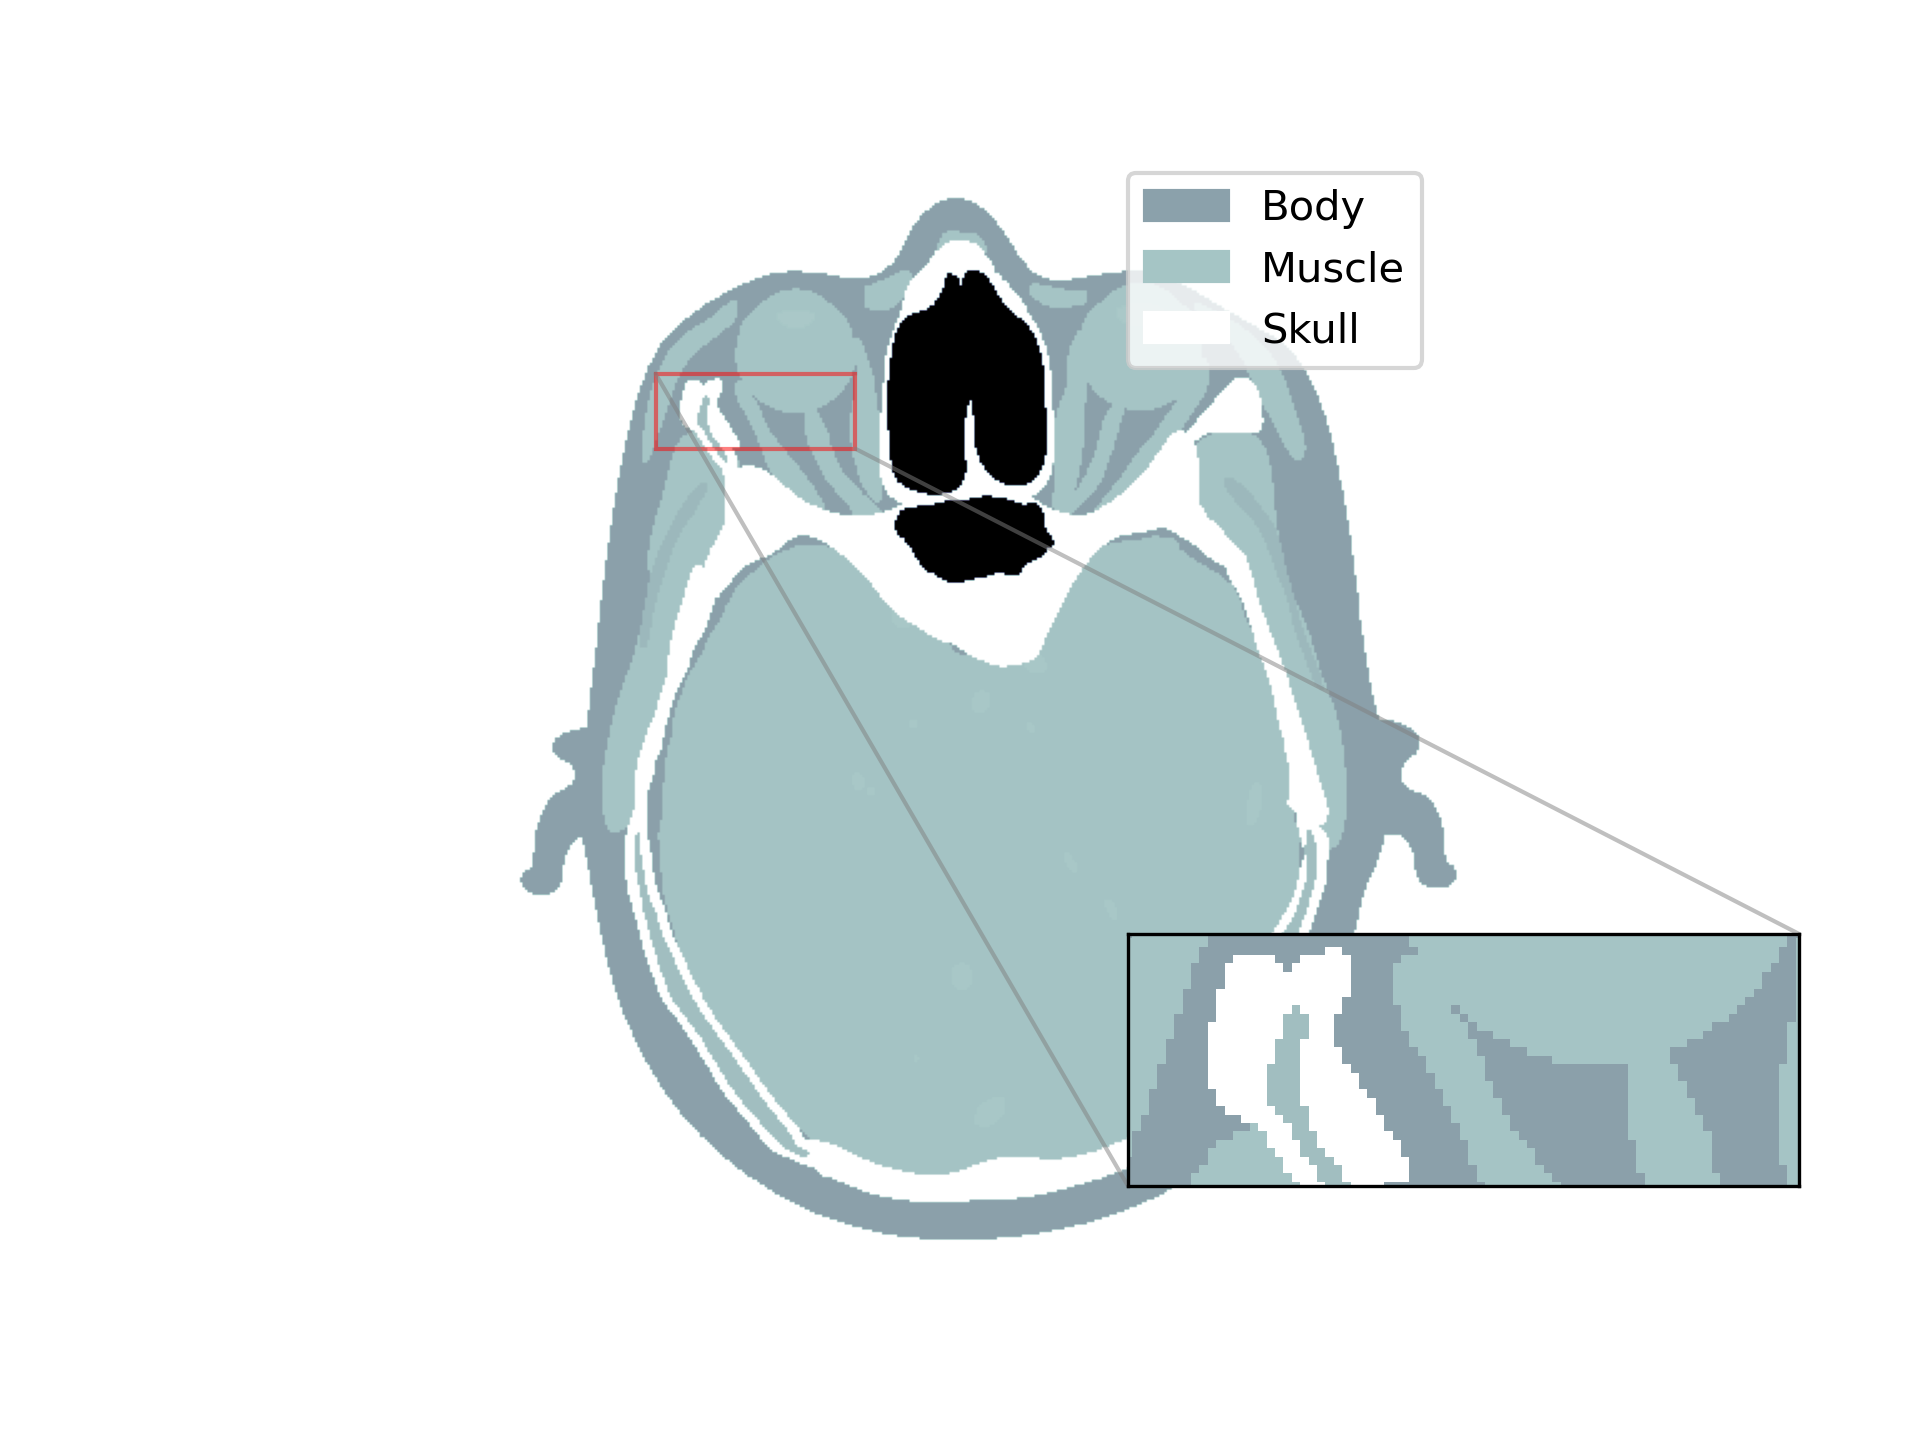

In [22]:
plt.figure(dpi=300)

im = np.fliplr(np.load('../../XCAT_phantom/head_gt.npy'))

im[ im == 0 ] = 0.01
plt.imshow(im,cmap='bone')
# plt.text(-70,-20,alph[ii],color='cornflowerblue',fontsize=14)

ax = plt.gca()
axins = ax.inset_axes([0.65, -0.25, 0.7, 0.9])

im2 = axins.imshow(im,cmap='bone')
# ax2.set_xlim([-0.05,0.2])
# ax2.set_ylim([0.05,0.11])
# sub region of the original image
x1, x2, y1, y2 = 60, 140, 110, 80
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')

axins.set_xticks([])
axins.set_yticks([])

ax.indicate_inset_zoom(axins,ec='red')
plt.axis('off')

# get the colors of the values, according to the 
# colormap used by imshow
colors = [ im2.cmap(im2.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label="{l}".format(l=labs[i]) ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(0.65, 1), loc=2, borderaxespad=0. )
plt.savefig('/home/xcite/fastcat_paper_2_tmi/figures/XCAT_1.pdf') #

<IPython.core.display.Javascript object>


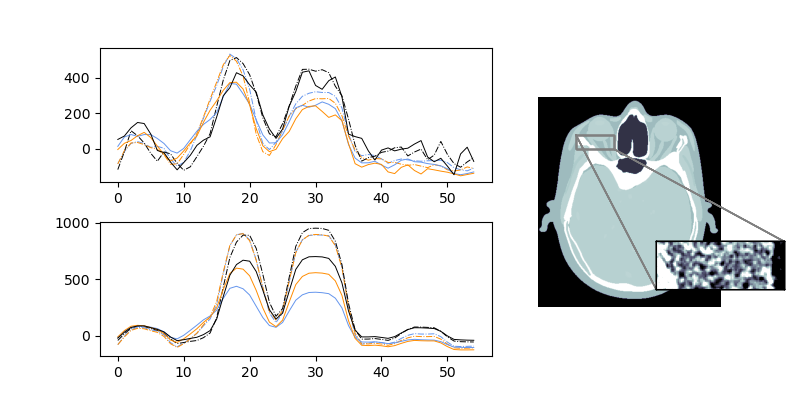

(-0.5, 383.5, 443.5, -0.5)

In [31]:
plt.figure(figsize=[8,4])#,dpi=300)

contrasts = np.load('head_scans.npy')

grid = plt.GridSpec(2, 3, wspace=0.4, hspace=0.3)

plt.subplot(grid[0,:2])
# scans = glob('XCATs/scan*')
index = 7

small_titles = ['120 kVp CWO','120 kVp CsI','120 kVp GOS','2.5 MV CWO','2.5 MV CsI','2.5 MV GOS']

fmt = ['-.','-.','-.','-','-','-']
color = ['cornflowerblue','darkorange','k','cornflowerblue','darkorange','k']

for ii, sc in enumerate(contrasts):
    
#     plt.subplot(2,3,ii+1)
    
#     plt.title(small_titles[ii])#scan.split('/')[-1].split('.')[0].split('scan_')[1])
    
    mm = np.mean(sc[385:410,610:640,index])
    mm_air = np.mean(sc[-350:-330,-320:-310,index])
    
    im_HU = (sc[:,:,index] - mm)/(mm_air - mm)*-1000
    
#     plt.imshow(sc[:,:,15],cmap='gray',vmax=mm+3*ss,vmin=mm-3*ss)
    plt.plot(np.mean(np.rot90(im_HU,3)[370:372,320+55:320+110],0),fmt[ii],label=small_titles[ii],linewidth=0.7,color=color[ii])
#     plt.axis('off')

# plt.legend()
plt.subplot(grid[1,:2])

contrasts = np.load('head_scans_no_noise.npy')

for ii, sc in enumerate(contrasts):
    
#     plt.subplot(2,3,ii+1)
    
#     plt.title(small_titles[ii])#scan.split('/')[-1].split('.')[0].split('scan_')[1])
    
    mm = np.mean(sc[385:410,610:640,index])
    mm_air = np.mean(sc[-350:-330,-320:-310,index])
    
    im_HU = (sc[:,:,index] - mm)/(mm_air - mm)*-1000
    
#     plt.imshow(sc[:,:,15],cmap='gray',vmax=mm+3*ss,vmin=mm-3*ss)
    plt.plot(np.mean(np.rot90(im_HU,3)[370:372,320+55:320+110],0),fmt[ii],linewidth=0.7,label=small_titles[ii],color=color[ii])
#     plt.axis('off')


plt.tight_layout()
plt.savefig('/home/xcite/fastcat_paper_2_tmi/figures/XCATs_contrast.pdf') #


plt.subplot(133)

im = np.load('../../XCAT_phantom/head_gt.npy')
plt.imshow(im,cmap='bone')

ax = plt.gca()
axins = ax.inset_axes([0.65, -0.25, 0.7, 0.9])

axins.imshow(im,cmap='bone')
# ax2.set_xlim([-0.05,0.2])
# ax2.set_ylim([0.05,0.11])
# sub region of the original image
x1, x2, y1, y2 = 80, 160, 110, 80
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')

axins.set_xticks([])
axins.set_yticks([])

ax.indicate_inset_zoom(axins)
plt.axis('off')

In [138]:
plt.imshow(sc[401:446,307:350,15],cmap='gray')

In [32]:
from array2gif import write_gif

images = []
for ii in range(phantom.img.T.shape[2]):
    images.append(np.tile(phantom.img.T[:,:,ii]/np.max(phantom.img.T[:,:,ii])*254,[3,1,1]))

write_gif(images, 'rgbbgr.gif', fps=5)

ValueError: The dataset has a value outside the range [0,255]
At position 0 in the list of arrays.

In [33]:
image

NameError: name 'image' is not defined

In [ ]:
images = []
for ii in range(phantom.img.T.shape[2]):
    images.append(imageio.imread(filename))
imageio.mimsave('/path/to/movie.gif', images)

In [19]:
np.save('contrasts',contrasts)
np.save('mtfs',mtfs)
np.save('labels',label)

/home/xcite/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


<IPython.core.display.Javascript object>


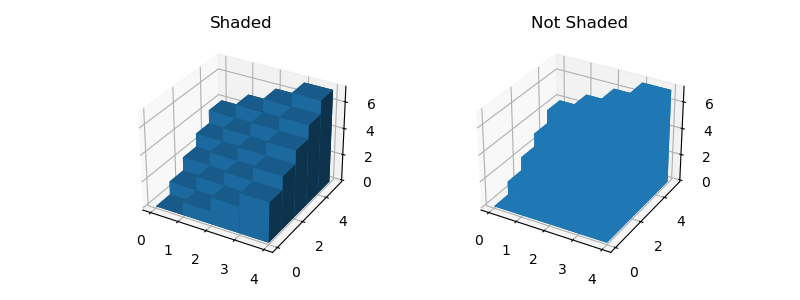

In [15]:
import numpy as np
import matplotlib.pyplot as plt
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

contrasts_i_want = [contrasts[ii][]]
# setup the figure and axes
fig = plt.figure(figsize=(8, 3))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

# fake data
_x = np.arange(4)
_y = np.arange(5)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

top = x + y
bottom = np.zeros_like(top)
width = depth = 1

ax1.bar3d(x, y, bottom, width, depth, top, shade=True)
ax1.set_title('Shaded')

plt.show()

In [69]:
from matplotlib import cm

<IPython.core.display.Javascript object>


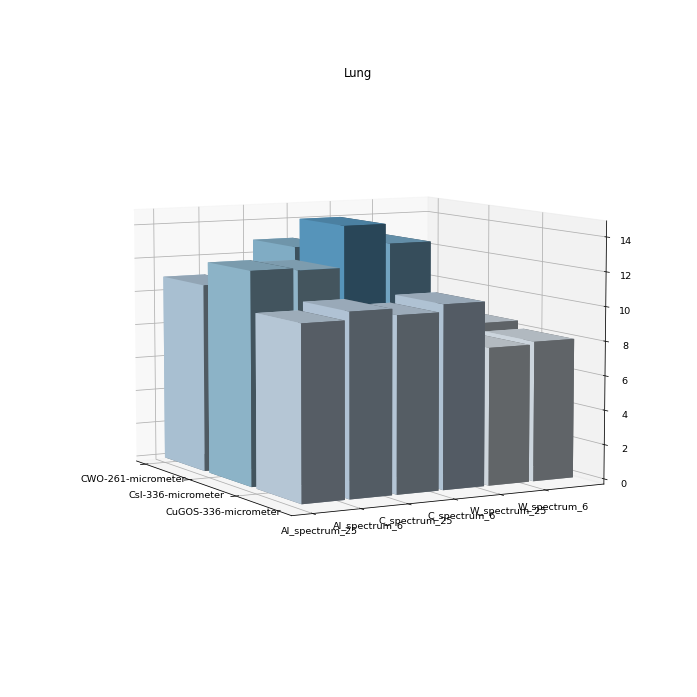

/home/xcite/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


<IPython.core.display.Javascript object>


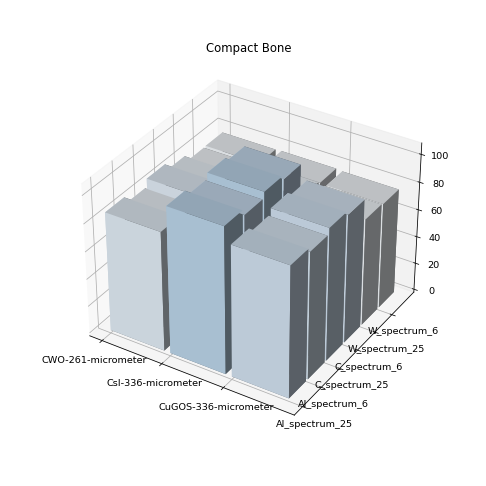

<IPython.core.display.Javascript object>


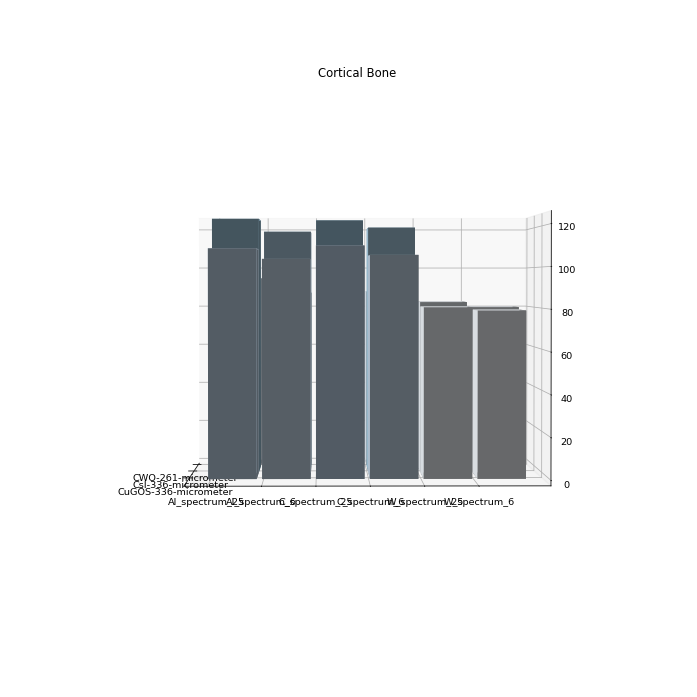

<IPython.core.display.Javascript object>


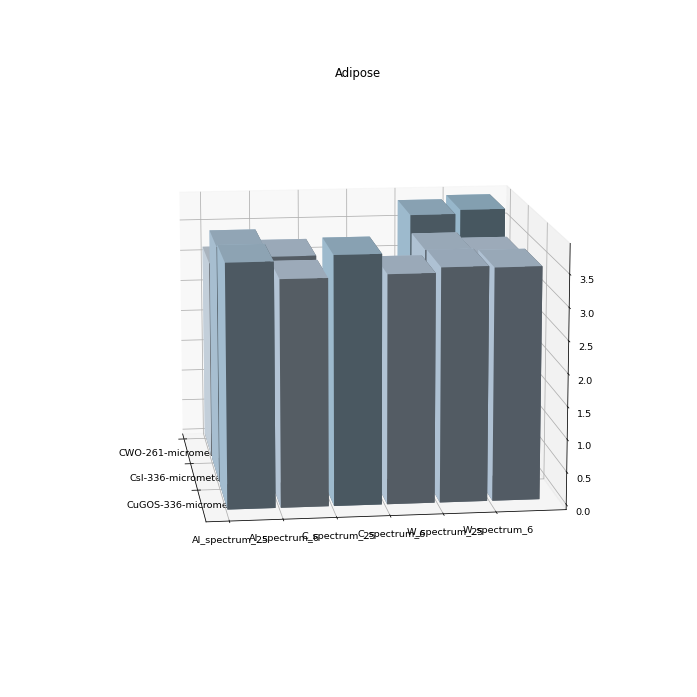

<IPython.core.display.Javascript object>


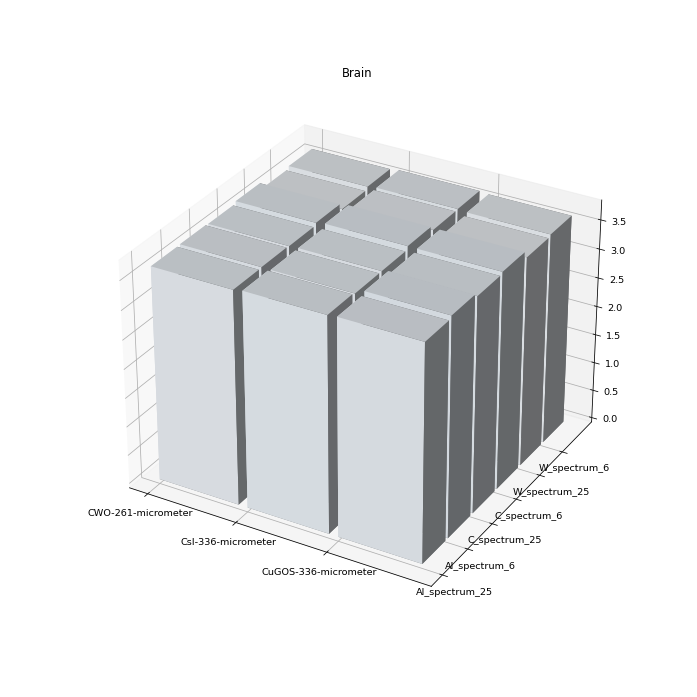

<IPython.core.display.Javascript object>


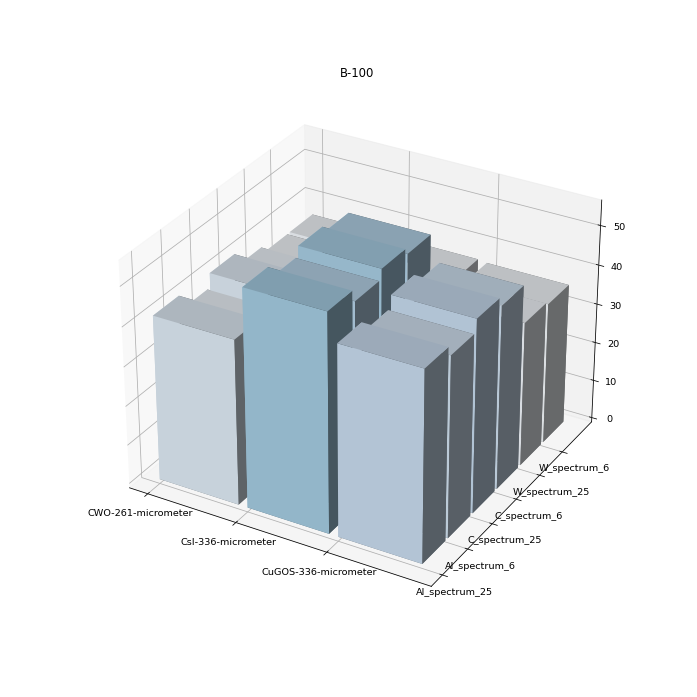

In [109]:
inds_i_want = [0,6,12,18,21,24]
shorts = ['Lung','Compact Bone','Cortical Bone','Adipose','Brain','B-100']

contrasts_only = [contrasts[ii][1] for ii in range(len(contrasts))]

contrast_ar = np.array(contrasts_only)[:,inds_i_want]

dets_i_want = [0,3,6]

contrasts_to_plot = contrast_ar[::3,0].reshape([3,6])

lx, ly = contrasts_to_plot.shape

_x = np.arange(lx)
_y = np.arange(ly)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

top = x + y
bottom = np.zeros_like(top)
width = depth = 0.9

specs = [spectra[kk].split('/')[-1].split('.')[0] for kk in range(len(spectra))]
detz = [MV_detectors[kk].split('/')[-1].split('.')[0] for kk in range(len(MV_detectors))]

for jj in range(len(inds_i_want)):
    
    contrasts_to_plot = contrast_ar[::3,jj].reshape([3,6]).flatten()#.reshape([len(spectra),int(len(contrasts)/len(spectra))])

    cmap = cm.get_cmap('Blues') # Get desired colormap - you can change this!
    max_height = np.max(contrasts_to_plot)   # get range of colorbars so we can normalize
    min_height = np.min(contrasts_to_plot)
    # scale each z to [0,1], and get their rgb values
    rgba = [cmap((k-min_height)/max_height) for k in contrasts_to_plot] 

    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(111, projection='3d')
    ax1.bar3d(x,y, bottom, width, depth, contrasts_to_plot,color=rgba, zsort='average', shade=True)
    ax1.set_title(shorts[jj])
    ax1.set_yticks(range(len(spectra)))
    ax1.set_yticklabels(sorted(specs))
    ax1.set_xticks(range(len(detz[::3])))
    ax1.set_xticklabels(sorted(detz)[::3])
    plt.tight_layout()
    
#     break

In [88]:
np.array(label)[:,1].reshape([len(spectra),int(len(contrasts)/len(spectra))])

array([['../fastcat/data/MV_spectra/Al_spectrum_25.txt',
        '../fastcat/data/MV_spectra/Al_spectrum_25.txt',
        '../fastcat/data/MV_spectra/Al_spectrum_25.txt',
        '../fastcat/data/MV_spectra/Al_spectrum_25.txt',
        '../fastcat/data/MV_spectra/Al_spectrum_25.txt',
        '../fastcat/data/MV_spectra/Al_spectrum_25.txt',
        '../fastcat/data/MV_spectra/Al_spectrum_25.txt',
        '../fastcat/data/MV_spectra/Al_spectrum_25.txt',
        '../fastcat/data/MV_spectra/Al_spectrum_25.txt'],
       ['../fastcat/data/MV_spectra/Al_spectrum_6.txt',
        '../fastcat/data/MV_spectra/Al_spectrum_6.txt',
        '../fastcat/data/MV_spectra/Al_spectrum_6.txt',
        '../fastcat/data/MV_spectra/Al_spectrum_6.txt',
        '../fastcat/data/MV_spectra/Al_spectrum_6.txt',
        '../fastcat/data/MV_spectra/Al_spectrum_6.txt',
        '../fastcat/data/MV_spectra/Al_spectrum_6.txt',
        '../fastcat/data/MV_spectra/Al_spectrum_6.txt',
        '../fastcat/data/MV_spectra/Al

In [108]:
detz

['CuGOS-392-micrometer',
 'CWO-784-micrometer',
 'CuGOS-784-micrometer',
 'CsI-392-micrometer',
 'CuGOS-336-micrometer',
 'CWO-392-micrometer',
 'CsI-784-micrometer',
 'CWO-261-micrometer',
 'CsI-336-micrometer']

In [89]:
np.array(label)[:,2].reshape([len(spectra),int(len(contrasts)/len(spectra))])

array([['../fastcat/data/Detectors/CWO-261-micrometer',
        '../fastcat/data/Detectors/CWO-392-micrometer',
        '../fastcat/data/Detectors/CWO-784-micrometer',
        '../fastcat/data/Detectors/CsI-336-micrometer',
        '../fastcat/data/Detectors/CsI-392-micrometer',
        '../fastcat/data/Detectors/CsI-784-micrometer',
        '../fastcat/data/Detectors/CuGOS-336-micrometer',
        '../fastcat/data/Detectors/CuGOS-392-micrometer',
        '../fastcat/data/Detectors/CuGOS-784-micrometer'],
       ['../fastcat/data/Detectors/CWO-261-micrometer',
        '../fastcat/data/Detectors/CWO-392-micrometer',
        '../fastcat/data/Detectors/CWO-784-micrometer',
        '../fastcat/data/Detectors/CsI-336-micrometer',
        '../fastcat/data/Detectors/CsI-392-micrometer',
        '../fastcat/data/Detectors/CsI-784-micrometer',
        '../fastcat/data/Detectors/CuGOS-336-micrometer',
        '../fastcat/data/Detectors/CuGOS-392-micrometer',
        '../fastcat/data/Detectors/Cu

In [91]:
contrast_ar[:,0].reshape([len(spectra),int(len(contrasts)/len(spectra))]).flatten()

array([10.94017538, 10.91813642, 10.94120732, 12.33236147, 12.30379796,
       12.30942803, 10.00898376, 10.00442507,  9.98202601, 11.30305439,
       11.2847624 , 11.26505964, 12.20998428, 12.16116432, 12.19630993,
       10.48481183, 10.47977956, 10.45809289, 12.89002102, 12.90404621,
       12.90185399, 14.61528942, 14.6249419 , 14.67340515, 10.11429075,
       10.09519276, 10.09851538, 12.41890821, 12.42877168, 12.46004897,
       13.46521681, 13.49752204, 13.46466291, 10.55510461, 10.56961973,
       10.55533228,  6.9022765 ,  6.91422433,  6.90450925,  8.19008695,
        8.18565598,  8.19404018,  7.91018029,  7.93289181,  7.92613491,
        7.14180457,  7.1456152 ,  7.13077258,  8.48668059,  8.509874  ,
        8.47786037,  8.07174783,  8.08153531,  8.06178995])

<IPython.core.display.Javascript object>


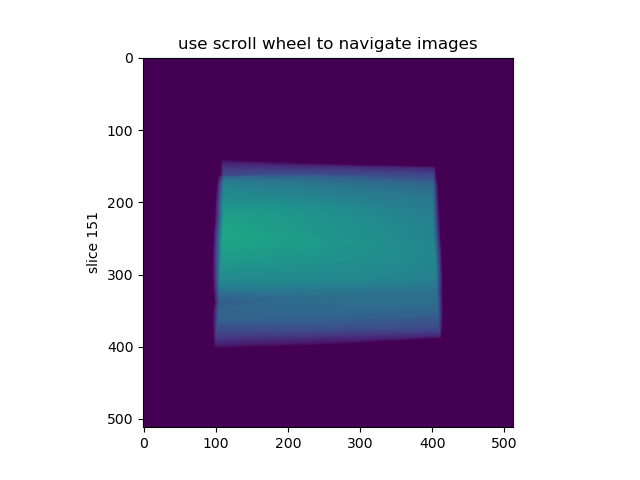

In [10]:
class IndexTracker(object):
    def __init__(self, ax, X):
        self.ax = ax
        ax.set_title('use scroll wheel to navigate images')

        self.X = X
        rows, cols, self.slices = X.shape
        self.ind = self.slices//2

        self.im = ax.imshow(self.X[:, :, self.ind])
        self.update()

    def onscroll(self, event):
        print("%s %s" % (event.button, event.step))
        if event.button == 'up':
            self.ind = (self.ind + 1) % self.slices
        else:
            self.ind = (self.ind - 1) % self.slices
        self.update()

    def update(self):
        self.im.set_data(self.X[:, :, self.ind])
        ax.set_ylabel('slice %s' % self.ind)
        self.im.axes.figure.canvas.draw()

fig, ax = plt.subplots(1, 1)

X = np.array(phantom.proj.T)

tracker = IndexTracker(ax, X)

fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()